In [31]:
import time
import numpy as np
import mujoco
import mujoco.viewer
import math
import os
# print(time.time())

m = mujoco.MjModel.from_xml_path(
    '/mnt/S58Data1/niujh/ForCode/ForSim/New/models/dynamic_4l.xml')
d = mujoco.MjData(m)


In [32]:
mujoco.mj_resetData(m,d)

In [33]:
d.geom_xpos[1][1]

0.0

In [34]:
def test():
    return (1,3)
a=test()
a[0]

1

In [35]:
print(m.njnt)
[m.joint(i).name for i in range(5)]
# m.joint(1)

44


['rail', 'neck', 'head', 'thigh_joint_fl', 'leg_joint_fl']

In [36]:
m.nsite
[m.site(i).name for i in range(5)]

['imu', 'thigh_link_fl', 'thigh_up_point_1_fl', 'leg_link_fl', 'knee_down_fl']

In [37]:
id=mujoco.mj_name2id(m,mujoco.mjtObj.mjOBJ_GEOM,"slope1")
quat=m.geom(id).pos
# m.site(1)
quat

array([ 0.   , -0.   ,  0.055])

In [38]:
m.ngeom
[m.geom(i).name for i in range(5)]

['', 'slope1', 'slope2', 'mouse_body', 'spine_mouse']

In [39]:
rot=np.zeros((9,1))
quat=np.array([-0.0003069622661036984, 0.00011459636274888154, -0.0011796679610890292, 0.9999992505123904])
mujoco.mju_quat2Mat(rot,quat)
print(rot[3][0])
rot.reshape(-1,3)

-0.0006141944433937511


array([[-9.99999785e-01,  6.13653701e-04,  2.29916781e-04],
       [-6.14194443e-04, -9.99997028e-01, -2.35926380e-03],
       [ 2.28468327e-04, -2.35940451e-03,  9.99997191e-01]])

In [40]:
import math
ang=math.atan2(0.43,0.90)
ang=ang/np.pi*180
ang

25.537434390636324

In [41]:
math.atan2(1,1)

0.7853981633974483

In [42]:
d.site_xpos[1]

array([0., 0., 0.])

In [43]:
# viewer = mujoco.viewer.launch_passive(m, d)

In [44]:
viewer.cam.azimuth=90

NameError: name 'viewer' is not defined

In [ ]:
m.stat.extent

3.200997512422418

In [ ]:
d.ctrl

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
m.opt.timestep

0.002

In [ ]:
print(np.cos(-8/180*np.pi))
print(np.sin(-8/180*np.pi))
print(0.2*np.sin(-16/180*np.pi))
print(0.2*np.cos(-16/180*np.pi))


0.9902680687415704
-0.13917310096006544
-0.05512747116339983
0.1922523391876638


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
class ETG_layer():
    def __init__(self, T, dt, H, sigma_sq, phase, amp, T2_radio):
        #T2_ratio mean the ratio forward t,在这里基本表示着周期的一半
        self.dt = dt
        self.T = T
        self.t = 0
        self.H = H
        self.sigma_sq = sigma_sq
        self.phase = phase
        self.amp = amp
        self.u = []
        self.omega = 2.0 * np.pi / T
        self.T2_ratio = T2_radio
        for h in range(H):
            t_now = h * self.T / (H - 0.9)
            self.u.append(self.forward(t_now))
        #self.u包含了u_ij的信息
        self.u = np.asarray(self.u).reshape(-1, 2)
        self.TD = 0

    def forward(self, t):
        x = []
        for i in range(self.phase.shape[0]):
            x.append(self.amp * np.sin(self.phase[i] + t * self.omega))
        return np.asarray(x).reshape(-1)

    def update(self, t=None):
        '''
        用于计算P=W*V+b中的V
        '''
        time = t if t is not None else self.t
        x = self.forward(time)
        self.t += self.dt
        r = []
        for i in range(self.H):
            dist = np.sum(np.power(x - self.u[i], 2)) / self.sigma_sq
            r.append(np.exp(-dist))
        r = np.asarray(r).reshape(-1)
        return r

    def update2(self, t=None, info=None):
        '''
        用于计算t时刻的V和t+T/2时刻的V，这里要计算不同时刻的V是为了得到常用的步态，即rf和lh足部同向，
        lf和rh足部同向且和另两条腿相差T/2 phase
        '''
        time = t if t is not None else self.t
        x = self.forward(time)
        x2 = self.forward(time + self.T2_ratio * self.T)
        self.t += self.dt
        r = []
        for i in range(self.H):
            dist = np.sum(np.power(x - self.u[i], 2)) / self.sigma_sq
            r.append(np.exp(-dist))
        r = np.asarray(r).reshape(-1)
        r2 = []
        for i in range(self.H):
            dist = np.sum(np.power(x2 - self.u[i], 2)) / self.sigma_sq
            r2.append(np.exp(-dist))
        r2 = np.asarray(r2).reshape(-1)
        return (r, r2)

    def observation_T(self):
        ts = np.arange(0, self.T, self.dt)
        x = {t: self.forward(t) for t in ts}
        r_all = {}
        for j in ts:
            r = []
            for i in range(self.H):
                dist = np.sum(np.power(x[j] - self.u[i], 2)) / self.sigma_sq
                r.append(np.exp(-dist))
            r_all[j] = np.asarray(r).reshape(-1)
        return r_all

    def get_phase(self):
        return self.forward(self.t - self.dt)

    def reset(self):
        self.t = 0
        self.TD = 0

In [ ]:
ETG_T=2
ETG_H=20
phase=np.array([-np.pi/2,0])
ETG_T2=0.5
ETG_dt=0.002
ETG_amp=0.2
ETG_agent = ETG_layer(ETG_T, ETG_dt, ETG_H, 0.04, phase, ETG_amp,
                          ETG_T2)


In [45]:
pointsSlope=[[ 0.01547304, -0.04082316],
       [-0.02824815, -0.04302008],
       [-0.01718435, -0.05053774],
       [-0.00024149, -0.05153843],
       [ 0.02100094, -0.05227396]]
pointsSlope=np.asarray(pointsSlope)
pointsSlope.shape

(5, 2)

In [46]:
pointsSlope.size

10

In [47]:
para_FU = [[-0.00, -0.045], [0.03, 0.01]]
para_FD = [[-0.00, -0.045], [0.03, 0.005]]
radSample=np.linspace(0,2*np.pi,10)
trj_ys=[]
trj_zs=[]
for cur_radian in radSample:
    if cur_radian<np.pi:
        originPoint=para_FU[0]
        ovalRadius=para_FU[1]
    else:
        originPoint=para_FD[0]
        ovalRadius=para_FD[1]
    trg_y = originPoint[0] + ovalRadius[0] * math.cos(cur_radian)
    trg_z = originPoint[1] + ovalRadius[1] * math.sin(cur_radian)
    trj_ys.append(trg_y)
    trj_zs.append(trg_z)
points=np.stack([trj_ys,trj_zs],axis=1)
def getETGinfo(points):
    b=np.mean(points,axis=0)
    points_t=points-b

    obs=[]
    # ts=radSample/(2*np.pi)*ETG_T
    ts=np.linspace(0,ETG_T,points.shape[0])
    for t in ts:
        v=ETG_agent.update(t)
        obs.append(v)
    obs=np.asarray(obs).reshape(-1,20)
    w=np.linalg.pinv(obs).dot(points_t)

    return w,b

# plt.scatter(trj_ys,trj_zs)


In [48]:
w_slope,b_slope=getETGinfo(pointsSlope)


In [49]:
def ETG_trj_plot(w,b):
    ts_new=np.linspace(0,ETG_T,100)
    obs1=[]
    for t in ts_new:
        v=ETG_agent.update(t)
        obs1.append(v)
    obs1=np.asarray(obs1).reshape(-1,20)
    points_new=obs1.dot(w)+b
    plt.plot(points_new[:,0],points_new[:,1])

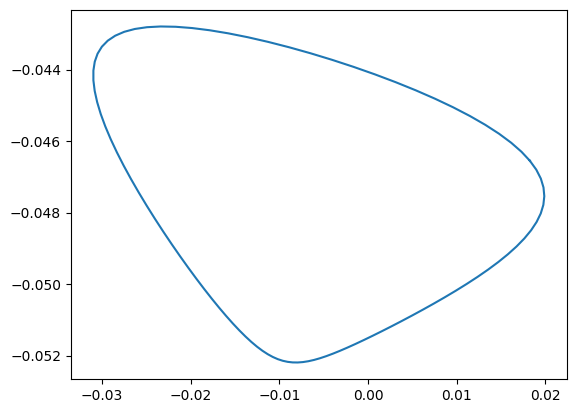

In [50]:
ETG_trj_plot(w_slope,b_slope)

In [51]:
x=np.arange(10)
x[::-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [52]:
def saveETGinfo(path,w,b,param):
    np.savez(path,w=w,b=b,param=param)
path="/mnt/S58Data1/niujh/ForCode/NewMujo_test/src/data/ETG_models/Slope_ETG.npz"
saveETGinfo(path,w_slope,b_slope,pointsSlope)

In [53]:
ETG_info=np.load("/home/niujh/ForCode/NewMujo_test/src/data/ETG_models/Slope_ETG.npz")
ETG_info['b']

FileNotFoundError: [Errno 2] No such file or directory: '/home/niujh/ForCode/NewMujo_test/src/data/ETG_models/Slope_ETG.npz'

In [ ]:
points
np.mean(points,axis=0)

array([ 0.003     , -0.04358218])

In [ ]:
np.pi*3/5/np.pi

0.6

In [ ]:
x=[[1,3,5]]
x[0][-1]

5